# Summary Statistics and data processing

In [36]:
import pandas as pd
import numpy as np
from numpy import nan
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

In [8]:
brca = pd.read_csv('/Users/junetam/Desktop/STAT432/Final Project/brca_data_w_subtypes.csv')
PR_Status = brca['PR.Status']
ER_Status = brca['ER.Status'] 
HER2 = brca['HER2.Final.Status']
HIST = brca['histological.type']
variables = brca.drop(['vital.status', 'PR.Status', 'ER.Status', 'HER2.Final.Status', 'histological.type'], axis=1)
outcomes = brca[['vital.status', 'PR.Status', 'ER.Status', 'HER2.Final.Status', 'histological.type']]
brca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Columns: 1941 entries, rs_CLEC3A to histological.type
dtypes: float64(827), int64(1110), object(4)
memory usage: 10.4+ MB


This dataset contains 1941 columns and 705 rows. 1936 features and 4 outcomes would be used for further analysis and modeling.

In [9]:
filter_brca = brca[((brca['PR.Status'] == 'Positive') | (brca['PR.Status'] == 'Negative')) & ((brca['ER.Status'] == 'Positive') | (brca['ER.Status'] == 'Negative')) & ((brca['HER2.Final.Status'] == 'Positive') | (brca['HER2.Final.Status'] == 'Negative'))]
brca_variables = filter_brca.drop(['vital.status', 'PR.Status', 'ER.Status', 'HER2.Final.Status', 'histological.type'], axis=1)
brca_outcomes = filter_brca[['vital.status', 'PR.Status', 'ER.Status', 'HER2.Final.Status', 'histological.type']]
brca_variables.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507 entries, 0 to 649
Columns: 1936 entries, rs_CLEC3A to pp_p90RSK.pT359.S363
dtypes: float64(827), int64(1109)
memory usage: 7.5 MB


Since we are interesting with the relationship between `PR.Status`, `ER.Status`, `HER2.Final.Status`, `histological.type` and other variables, we will only keep observations with values “Positive” and “Negative” and “infiltrating lobular carcinoma” and “infiltrating ductal carcinoma”.  

### To do univariate analysis for these data, we would do these respectively for categorical and continuous variables. 
#### Before that we would check for the presence of missing values in this dataset.
#### For categorical variables, we would first examine that if the variable that is extremely unbalanced. And for the continuous variables, we would identifying the outliers.

In [14]:
missing_value = brca_variables.isnull().sum()
missing_value[missing_value!=0]

Series([], dtype: int64)

#### It is good that there is no missing value appeared for all the features in the dataset, so we could move forward for further analysis on this data.
According to the data description on Kaggle, there are four groups of features, which are `mu` (somatic mutation (yes, no)), `cn` (copy number variation as calculated by gistic (-2,-1,0,1,2)), `rs` (rna sequencing i.e. gene expression) and `pp` (phospho-protein levels). 

To get an in-depth understanding of our data and do a univariate analysis for each variable, we need to check the balence between different categories for each categorical variable (`mu` and `cn`) and identify outliers for continuous variables (`rs` and `pp`).

In [16]:
filter_col_mu = [col for col in brca_variables if col.startswith('mu')]
filter_col_cn = [col for col in brca_variables if col.startswith('cn')]
filter_col_rs = [col for col in brca_variables if col.startswith('rs')]
filter_col_pp = [col for col in brca_variables if col.startswith('pp')]
brca_variables_mu = brca_variables[filter_col_mu]
brca_variables_cn = brca_variables[filter_col_cn]
brca_variables_rs = brca_variables[filter_col_rs]
brca_variables_pp = brca_variables[filter_col_pp]

## Check balance between each category for categorical predictors:
#### For `mu` and `cn` continuous variables, we need to the disturbution of observations' response for each category that might affect the prediction effect for later modeling.

In [18]:
## Check balance between each category for mu variables
def check_balance(df2):
    col = []
    for column in df2:
        if df2.loc[:,column].value_counts()[0] - df2.loc[:,column].value_counts()[1] > 0:
            dif = df2.loc[:,column].value_counts()[1]/df2.loc[:,column].value_counts()[0]
            if dif < 0.05:
                col.append(column)
        else:
            dif = df2.loc[:,column].value_counts()[0]/df2.loc[:,column].value_counts()[1]
            if dif < 0.05:
                col.append(column)
    return col

In [23]:
brca_variables_mu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507 entries, 0 to 649
Columns: 249 entries, mu_ANK3 to mu_PEG3
dtypes: int64(249)
memory usage: 990.2 KB


In [22]:
len(check_balance(brca_variables_mu))

231

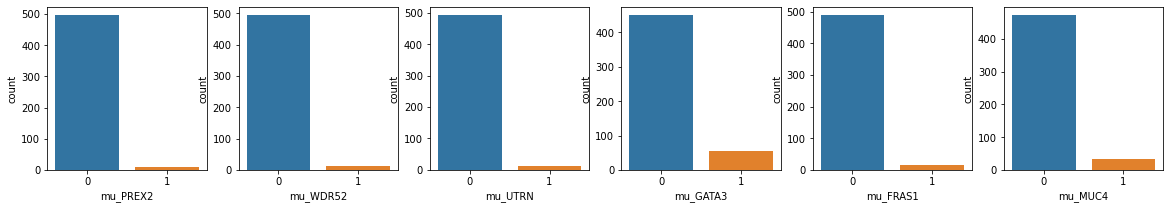

In [223]:
random.seed(0)
sample_mu = brca_variables_mu.sample(n=6,axis='columns')
##Visualize the randomly selected variables
count=1
plt.figure(figsize=(20,3))
for i in sample_mu.columns.tolist():
    plt.subplot(1,len(sample_mu.columns.tolist()),count)
    sns.countplot(x=i, data=brca_variables_mu)
    count+=1
plt.show()

#### By looking at the frequency of the two categories of  `mu`  binary  variables, a vast majority of these variables are unbalanced. 231 out of 249 variables have less than a ratio of 5:100 of frequency.

In [26]:
## Check balance between each category for cn variables
def check_balance_1(df2):
    col = []
    for column in df2:
        if df2.loc[:,column].value_counts().max() - df2.loc[:,column].value_counts().min() > 172:
            col.append(column)
    return col

In [28]:
brca_variables_cn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507 entries, 0 to 649
Columns: 860 entries, cn_ISG15 to cn_MLC1
dtypes: int64(860)
memory usage: 3.3 MB


In [29]:
len(check_balance_1(brca_variables_cn))

843

#### By looking at the frequency disturbution of the five categories of  `cn` categorical variables, also, observation records of these variables are not equally disturbuted among those five categories. Let take some examples to see how they are disturbuted.

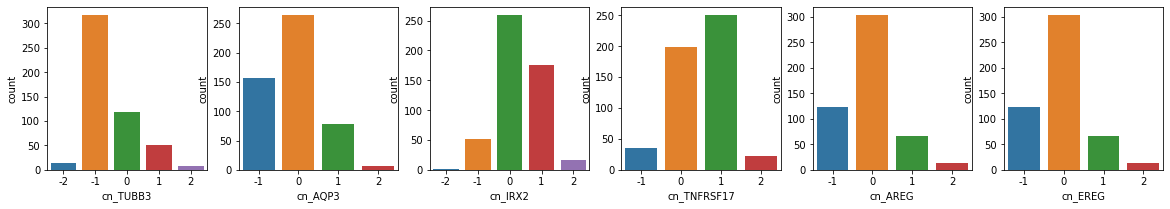

In [131]:
random.seed(0)
sample_cn = brca_variables_cn.sample(n=6,axis='columns')

##Visualize the randomly selected variables
count=1
plt.figure(figsize=(20,3))
for i in sample_cn.columns.tolist():
    plt.subplot(1,len(sample_cn.columns.tolist()),count)
    sns.countplot(x=i, data=brca_variables_cn)
    count+=1
plt.show()

6 `cn` variables are randomly selected with their corresponding frequency plot, we can see that observations' records vary quite significantly, and their responses are not evenly disturbuted among 4 categories (-2,-1,0,1,2). A vast majority of patients reported 0 and 1 number variation as calculated by gistic for these predictor. 

Since classification algorithms are sensitive to unbalance in the predictor classes and an unbalanced dataset will bias the prediction model towards the more common class, here in this case is 0 and 1, we might need to consider some alternatives for dealing with these predictors: 

1. Doing  sampling for these discrete variables before doing prediction with classification modeling to ensure an equal number of observations for each class;
2. Dropping the class that has only few observations to avoid bias caused by undersampling. 

## Identifying outliers for continuous predictors:
### For `rs` and `pp` continuous variables, we need to check the existence of outliers that might affect the prediction effect for later modeling.

#### `rs` variables

In [246]:
brca_variables_rs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507 entries, 0 to 649
Columns: 604 entries, rs_CLEC3A to rs_HEPN1
dtypes: float64(604)
memory usage: 2.4 MB


In [133]:
## Identifying variables with outliners, and their corresponding number of outliers
def identify_outlier(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    return df_final, len(df_final)
def find_col(df2):
    col = []
    num = []
    for column in df2:
        if identify_outlier(df2.loc[:,column])[1] != 0:
            col.append(column)
            num.append(identify_outlier(df2.loc[:,column])[1])
    res = {col[i]: num[i] for i in range(len(col))}
    return res

In [245]:
def getList(dict):
    return list(dict.keys())
rs_outliers = getList(find_col(brca_variables_rs))
# list of columns with outliers
rs_outliers_num = list(find_col(brca_variables_rs). values())
# list of numbers of outliers
brca_variables_rs_outliers = brca_variables_rs[rs_outliers]
pd_rs_outliers = pd.DataFrame(find_col(brca_variables_rs).items())
pd_rs_outliers

,0,1
0,rs_S100A7,9
1,rs_SERPINA6,1
2,rs_AGR3,40
3,rs_C4orf7,5
4,rs_SLC30A8,1
...,...,...
300,rs_DEFB132,8
301,rs_APOB,26
302,rs_SPHKAP,11
303,rs_DPYSL5,58


In [242]:
bins = [0, 10, 50, 100, 500]
rs_ol_counts = pd.cut(pd_rs_outliers.iloc[:,1], bins)
pd.value_counts(rs_ol_counts)

(0, 10]       180
(10, 50]      104
(50, 100]      21
(100, 500]      0
Name: 1, dtype: int64

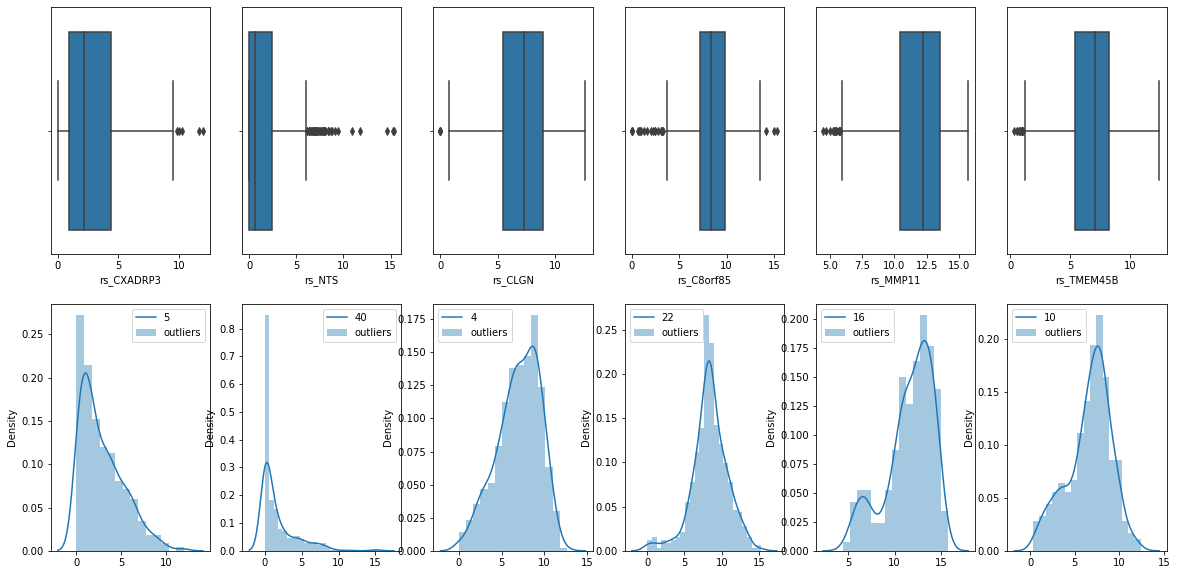

In [222]:
random.seed(5)
sample_rs = brca_variables_rs[random.choices(rs_outliers, k=6)]

##Visualize the randomly selected variables with outliers
count=1
plt.figure(figsize=(20,10))
for i in sample_rs.columns.tolist():
    plt.subplot(2,len(sample_rs.columns.tolist()),count)
    sns.boxplot(x=i, data=brca_variables_rs)
    
    plt.subplot(2,len(sample_rs.columns.tolist()),count+6)
    sns.distplot(brca_variables_rs[[i]])
    plt.legend(labels=[find_col(brca_variables_rs).get(i),'outliers'])
    count+=1
plt.show()


For `rs` variables, half of them have some numbers of outliers (305 out of 604) among which half have numbers of outliers less than 10. We can see from their histograms that the observations for these `rs` predictors do not follow a normal disturbution. As the algorithm is more likely to be biased when the data distribution is skewed, we might consider doing a transformation. Let's try some. The first histogram of the `rs_CXADRP3` variable above are right-skewed, and we might do a Log Transformation for it. And for the second one, there are a large number of extreme values, we might consider replacing those values with the median. In this unvariate analysis, we can't tell the significance of a certain variable for prediction accuracy and the effect outliers, decisions of using a transformation or eliminating the outliers is subject to the choice of classification algorithms.

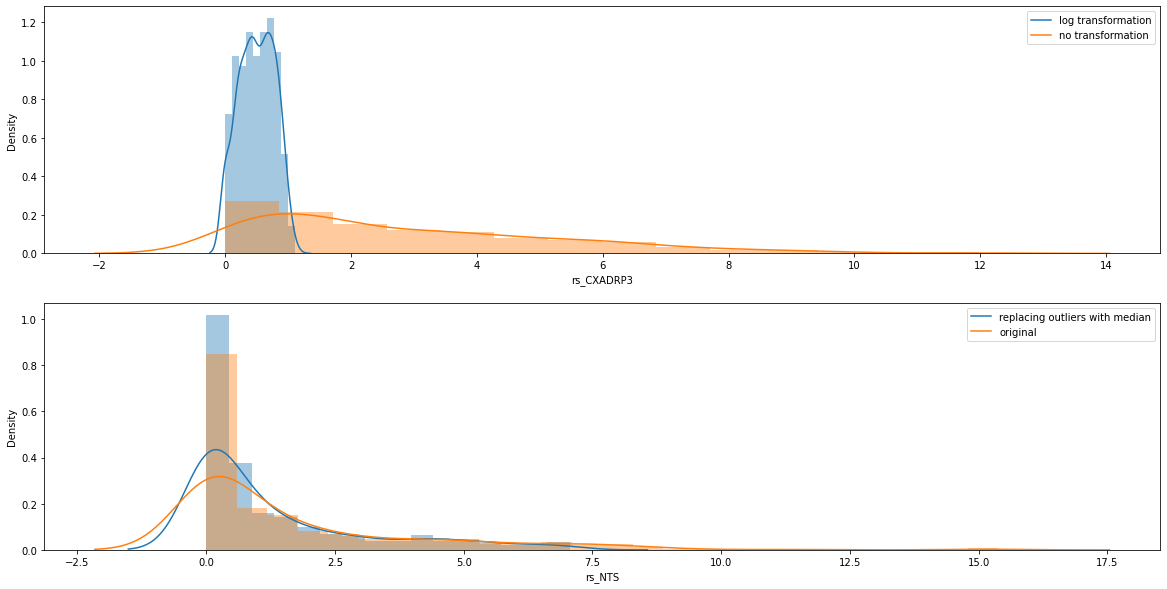

In [271]:
plt.figure(figsize=(20,10))
## Log transformation
plt.subplot(2,1,1)
sns.distplot(np.log10(brca_variables_rs['rs_CXADRP3']+1))
sns.distplot(brca_variables_rs['rs_CXADRP3'])
plt.legend(labels=['log transformation','original'])
## Replacing outliers with median
plt.subplot(2,1,2)
replaceing = np.where(brca_variables_rs['rs_NTS'] > brca_variables_rs['rs_NTS'].quantile(0.95), brca_variables_rs['rs_NTS'].quantile(0.5), brca_variables_rs['rs_NTS'])
sns.distplot(replaceing)
sns.distplot(brca_variables_rs['rs_NTS'])
plt.legend(labels=['replacing outliers with median','original'])        

For variable `rs_CXADRP3`, right-skewed with 5 outliers, after a log transformation, the disturbution is normalized and is more likely to enhance the accuracy for predictive modeling. 
For variable `rs_NTS`, right-skewed with 40 extreme outliers, after replacing those outliers with the median, has a better disturbution of observations. However, even outliers can adversely affect the training process of predictive modelling and resulting in a loss of accuracy, some of them might be valueable for considering some particular cases.

#### `pp` variables

In [237]:
brca_variables_pp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507 entries, 0 to 649
Columns: 223 entries, pp_X14.3.3.beta to pp_p90RSK.pT359.S363
dtypes: float64(223)
memory usage: 903.4 KB


In [240]:
pp_outliers = getList(find_col(brca_variables_pp))
# list of columns with outliers
pp_outliers_num = list(find_col(brca_variables_pp). values())
# list of numbers of outliers
brca_variables_pp_outliers = brca_variables_pp[pp_outliers]
pd_pp_outliers = pd.DataFrame(find_col(brca_variables_pp).items())
pd_pp_outliers

,0,1
0,pp_X14.3.3.beta,23
1,pp_X14.3.3.epsilon,19
2,pp_X14.3.3.zeta,14
3,pp_X4E.BP1,19
4,pp_X4E.BP1.pS65,10
...,...,...
215,pp_p62.LCK.ligand,12
216,pp_p70S6K,36
217,pp_p70S6K.pT389,26
218,pp_p90RSK,9


In [244]:
bins = [0, 10, 50, 100, 500]
pp_ol_counts = pd.cut(pd_pp_outliers.iloc[:,1], bins)
pd.value_counts(pp_ol_counts)

(10, 50]      155
(0, 10]        60
(50, 100]       5
(100, 500]      0
Name: 1, dtype: int64

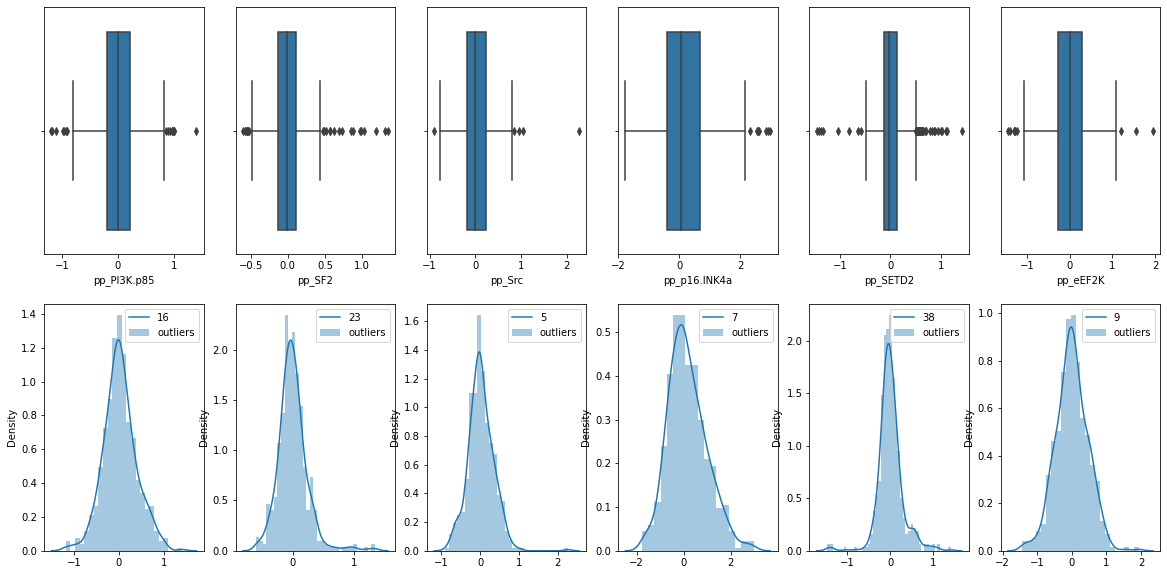

In [229]:
random.seed(5)
sample_pp = brca_variables_pp[random.choices(pp_outliers, k=6)]

##Visualize the randomly selected variables with outliers
count=1
plt.figure(figsize=(20,10))
for i in sample_pp.columns.tolist():
    plt.subplot(2,len(sample_pp.columns.tolist()),count)
    sns.boxplot(x=i, data=brca_variables_pp)
    
    plt.subplot(2,len(sample_pp.columns.tolist()),count+6)
    sns.distplot(brca_variables_pp[[i]])
    plt.legend(labels=[find_col(brca_variables_pp).get(i),'outliers'])
    count+=1
plt.show()


For `pp` variables, almost every variable has some numbers of outliers (220 out of 223) and fewer than 20 percent of them have a number of outliers less than 10. We can see from their histograms that the observations for these `pp` predictors generally follow a normal disturbution. 